# QA con metadata filtering e ricerca di una label che rappresenti la dimensione delle imprese nei documenti

In [1]:
!pip install pypdf
!pip install langchain
!pip install openai==0.28.1
!pip install chromadb
!pip install tiktoken
!pip install pinecone-client
!pip install python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.6/277.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.8/177.8 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.4/502.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 11.4 MB/s

In [2]:
from google.colab import drive, files
import os
from dotenv import load_dotenv, find_dotenv
drive.mount("/content/drive/", force_remount=False)
%cd "/content/drive/My Drive/"
load_dotenv('./Lab_Python/.env')

Mounted at /content/drive/
/content/drive/My Drive


True

In [3]:
import pandas as pd

fine_tuning_dataset = pd.read_json("./Tesi/fine_tune_improved.json")
dataset_query = pd.read_json("./Tesi/prova_domande_fine_tuning.json")

In [4]:
query1 = fine_tuning_dataset.prompt[0]
print(query1)

Qual è il modo per partecipare all'Avviso MicroPrestito della Regione Puglia? in riferimento al documento: 'Scheda MicroPrestito della Regione Puglia - edizione 2021.pdf'


In [5]:
import datetime
current_date = datetime.datetime.now().date()
if current_date < datetime.date(2023, 9, 2):
    llm_name = "gpt-3.5-turbo-0301"
else:
    llm_name = "gpt-3.5-turbo"
print(llm_name)

gpt-3.5-turbo


api langsmith per vedere le chiamate

In [6]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.langchain.plus"
os.environ["LANGCHAIN_API_KEY"] = "ls__0554eeed658141b4a601195abd6c737d"

Carico i documenti ed estraggo il contenuto della pagina e i suoi metadata

In [7]:
import os
from langchain.document_loaders import PyPDFLoader

pdf_directory = "Tesi/Documenti"

pdf_files = [file for file in os.listdir(pdf_directory) if file.endswith('.pdf')]

docs = []

for pdf_file in pdf_files:
  file_path = os.path.join(pdf_directory, pdf_file)

  loader = PyPDFLoader(file_path)
  loaded_docs = loader.load()

  for doc in loaded_docs:
      doc.metadata["source"] = pdf_file
      docs.append(doc)


In [ ]:
docs[0]

Document(page_content='  \n \n14 ottobre  2021 Pag 1 di 2 Centro Servizi Sistema Puglia  \nwww.sistema.puglia.it  \n \n \nScheda: Avviso MicroPrestito  della  Regione  Puglia  \n \nInformazioni  generali  Titolo  bando  MicroPrestito  della  Regione  Puglia  \nDescrizione  L’Avviso  è stato  adottato  per far fronte  alle esigenze  delle  imprese  derivanti  dalle  \nripercussioni  economiche  causate  dall’emergenza  epidemiologia  Covid -19. La \nmisura vuole garantire la continuità dell’operatività aziendale  e la salvaguardia \ndell’occupazione.  \nLe disposizioni  dell’Avviso  sono  conformi  all’approvazione  dell’Aiuto  di Stato  SA. \n57021 -Italia -Covid19 regime quadro del 21 maggio 2020 da parte della  \nCommissione  europea  ai sensi dell’art.  108 del TFUE e  s.m.i.  \nRisultati  attesi  La misura  sostiene  l’accesso  al credito  attraverso  interventi  di micro -finanza  \nche consistono  in mutui  concessi  a tasso zero  e senza  garanzie.  \nDestinatari  Il sistema  ec

Documenti che voglio usare: 9-28

In [ ]:
for i, doc in enumerate(docs):
    print(f"{i} {doc.metadata['source']} {doc.metadata['page']}")

Documenti su cui provo a fare il labeling

In [8]:
test_docs = []

for doc in docs:
  if doc.metadata['source'] == 'Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf':
    test_docs.append(doc)
  if doc.metadata['source'] == 'Programmi Integrati di Agevolazioni PIA Piccole Imprese (Art_ 27 Reg_ Regionale 17_2014 e s_m_i_).pdf':
    test_docs.append(doc)
  if doc.metadata['source'] == 'Contratti di Programma per Grandi Imprese Singole o con PMI aderenti (Art_ 17 Reg_ Regionale 17_2014 e s_m_i_).pdf':
    test_docs.append(doc)

In [9]:
for i, doc in enumerate(test_docs):
    print(f"{i} {doc.metadata['source']} {doc.metadata['page']}")

0 Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf 0
1 Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf 1
2 Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf 2
3 Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf 3
4 Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf 4
5 Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf 5
6 Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf 6
7 Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf 7
8 Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 

Funzione che conta i token che gpt-3.5-turbo userà per il testo.

In [10]:
import tiktoken

tokenizer = tiktoken.get_encoding('cl100k_base')

# create the length function
def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

In [11]:
token_counts = [tiktoken_len(doc.page_content) for doc in test_docs]

In [12]:
print(f"""Min: {min(token_counts)}
Avg: {int(sum(token_counts) / len(token_counts))}
Max: {max(token_counts)}""")

Min: 383
Avg: 855
Max: 1033


Plottiamo il contatore di token per vedere la frequenza di quanti token hanno le pagine

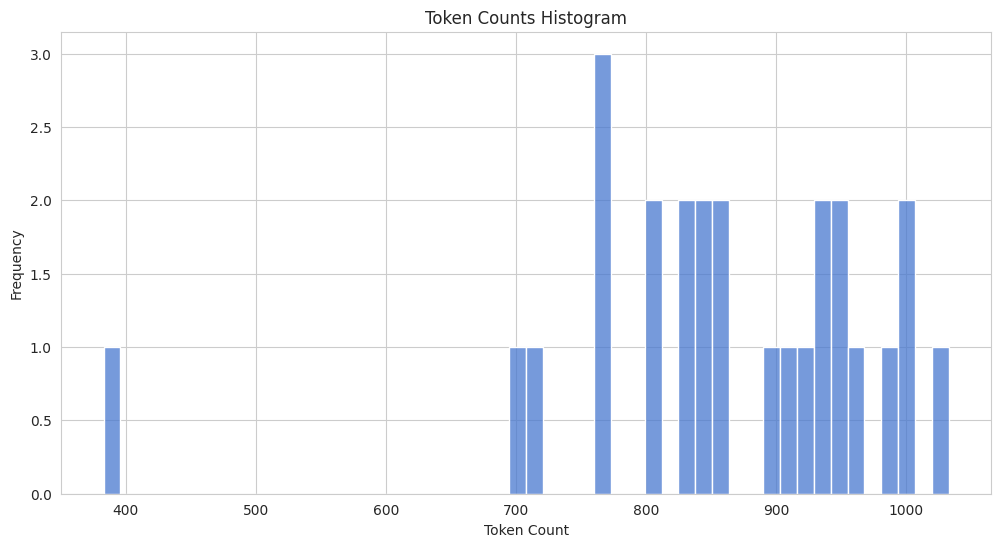

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("muted")

plt.figure(figsize=(12, 6))
sns.histplot(token_counts, kde=False, bins=50)

plt.title("Token Counts Histogram")
plt.xlabel("Token Count")
plt.ylabel("Frequency")

plt.show()

Andiamo a fare il labelling con create_metadata_tagger per trovare il Tipo di impresa a cui si riferisce il chunk

In [14]:
from langchain.prompts import ChatPromptTemplate

from langchain.chat_models import ChatOpenAI
from langchain.document_transformers.openai_functions import create_metadata_tagger
from langchain.schema import Document
from typing import Literal

from pydantic import BaseModel, Field

prompt = ChatPromptTemplate.from_template(
    """Identifica il tipo di impresa a cui è riferito il documento e specifica se è "Piccole Imprese", "Medie Imprese", "Grandi Imprese" se nessuna delle tre "Non classificato" se a entrambi "Piccole e Medie Imprese":
{input}
"""
)

class Properties(BaseModel):
    Tipo_Imprese: Literal['Non classificato', 'Piccole Imprese','Piccole e Medie Imprese', 'Medie Imprese', 'Grandi Imprese']

# Must be an OpenAI model that supports functions
llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo-0613")

document_transformer = create_metadata_tagger(Properties, llm=llm, prompt = prompt)

enhanced_documents = document_transformer.transform_documents(test_docs)

In [15]:
for i, doc in enumerate(enhanced_documents):
    print(f"{i} {doc.metadata}")

0 {'Tipo_Imprese': 'Piccole e Medie Imprese', 'source': 'Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf', 'page': 0}
1 {'Tipo_Imprese': 'Non classificato', 'source': 'Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf', 'page': 1}
2 {'Tipo_Imprese': 'Non classificato', 'source': 'Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf', 'page': 2}
3 {'Tipo_Imprese': 'Non classificato', 'source': 'Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf', 'page': 3}
4 {'Tipo_Imprese': 'Non classificato', 'source': 'Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf', 'page': 4}
5 {'Tipo_Imprese': 'Non classificato', 'source': 'Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Cap

In [16]:
import pickle

with open('./Metadata_tagging_RAG/documenti_labellati_start.pkl', 'wb') as file:
    pickle.dump(enhanced_documents, file)

with open('./Metadata_tagging_RAG/documenti_labellati_start.pkl', 'rb') as file:
    enhanced_documents = pickle.load(file)


In [17]:
label = None
source = None

for doc in enhanced_documents:
  current_source = doc.metadata['source']
  current_label = doc.metadata['Tipo_Imprese']

  if current_label == 'Non classificato' and current_source == source:
    doc.metadata['Tipo_Imprese'] = label

  label = current_label
  source = current_source


Ho fatto un post-processing assegnando la label precedente al documento Non classificato successivo

In [18]:
for i, doc in enumerate(enhanced_documents):
    print(f"{i} {doc.metadata}")

0 {'Tipo_Imprese': 'Piccole e Medie Imprese', 'source': 'Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf', 'page': 0}
1 {'Tipo_Imprese': 'Piccole e Medie Imprese', 'source': 'Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf', 'page': 1}
2 {'Tipo_Imprese': 'Non classificato', 'source': 'Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf', 'page': 2}
3 {'Tipo_Imprese': 'Non classificato', 'source': 'Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf', 'page': 3}
4 {'Tipo_Imprese': 'Non classificato', 'source': 'Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf', 'page': 4}
5 {'Tipo_Imprese': 'Non classificato', 'source': 'Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo

#Chunking the Text
gpt-3.5-turbo supporta un insieme di 4096 tokens — ciò significa che i token di input + i token di output generati (/completion) non possono totalizzare più di 4096 senza andare in errore.

Quindi dobbiamo mantenerci al di sotto di questo valore al 100%. Se assumiamo un margine  di ~ 2000 token per il prompt di input in gpt-3.5-turbo, lasciando ~ 2000 token per la conversation history e il completamento della conversazione.

Con questo limite di ~2000 token potremmo voler includere cinque chunk di informazioni rilevanti, il che significa che ogni chunk non può essere lungo più di 450 token.

Per creare questi chunk utilizziamo RecursiveCharacterTextSplitter di LangChain. Per misurare la lunghezza degli snippet abbiamo bisogno anche di una funzione di lunghezza. Questa è una funzione che conta il numero di token all'interno del testo (dopo la tokenizzazione utilizzando il tokenizer gpt-3.5-turbo) e restituisce quel numero.

La funzione salverà anche i metadata

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=450,
    chunk_overlap=20,  # number of tokens overlap between chunks
    length_function=tiktoken_len,
    separators=['\n\n', '\n', ' ', '']
)


split_docs = []

for document in enhanced_documents:
  metadata = document.metadata
  page_content = document.page_content


  split_content = text_splitter.create_documents([page_content])


  for content_chunk in split_content:
    print(content_chunk)
    split_docs.append(Document(metadata = metadata, page_content = content_chunk.page_content))



In [20]:
for i, doc in enumerate(split_docs):
    print(f"{i} {doc.metadata}")

0 {'Tipo_Imprese': 'Piccole e Medie Imprese', 'source': 'Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf', 'page': 0}
1 {'Tipo_Imprese': 'Piccole e Medie Imprese', 'source': 'Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf', 'page': 0}
2 {'Tipo_Imprese': 'Piccole e Medie Imprese', 'source': 'Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf', 'page': 1}
3 {'Tipo_Imprese': 'Piccole e Medie Imprese', 'source': 'Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf', 'page': 1}
4 {'Tipo_Imprese': 'Non classificato', 'source': 'Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf', 'page': 2}
5 {'Tipo_Imprese': 'Non classificato', 'source': 'Aiuti agli Investimenti delle Piccole e Medie I

In [ ]:
import pandas as pd

df= pd.DataFrame(split_docs)

df.to_csv("df_with metadata_tag", index=False)
df

In [ ]:
import pandas as pd

# Assuming df is your DataFrame
pd.set_option('display.max_colwidth', None)

# Display the DataFrame
df.head(30)


In [28]:
split_docs[34]

Document(page_content='istruttori.  \nInfine, con esclusivo riferimento ai progetti ricadenti nell’ambito della sottocategoria “38.22.00 \nTrattamento e smaltimento di rifiuti pericolosi, limitatamente ai rifiuti di amianto” saranno \nvalutate favorevolmente le iniziative che prevedano esclusivamente il t rattamento e smaltimento \ndel rifiuto di amianto raccolto nell’ambito della Regione Puglia. Le tariffe applicate dovranno \nessere esposte nel business plan e dovranno tenere conto dei benefici rivenienti dall’agevolazione \nrichiesta sul piano economico finanz iario dell’impresa.  \nI Codici Ateco ammissibili sono riportati sul sito www.sistema.puglia.it  nella sezione PIA Medie \nImprese.', metadata={'Tipo_Imprese': 'Non classificato', 'source': 'Contratti di Programma per Grandi Imprese Singole o con PMI aderenti (Art_ 17 Reg_ Regionale 17_2014 e s_m_i_).pdf', 'page': 2})

Qui provo a cambiare a mano una label decisa da me

In [31]:
for doc in split_docs:
  if doc.metadata['source'] == "Contratti di Programma per Grandi Imprese Singole o con PMI aderenti (Art_ 17 Reg_ Regionale 17_2014 e s_m_i_).pdf" and doc.metadata['page'] == 2:
    doc.metadata['Tipo_Imprese'] = 'Medie Imprese'
split_docs[34].metadata

{'Tipo_Imprese': 'Medie Imprese',
 'source': 'Contratti di Programma per Grandi Imprese Singole o con PMI aderenti (Art_ 17 Reg_ Regionale 17_2014 e s_m_i_).pdf',
 'page': 2}

Voglio salvarmi il dataset con oggetti di tipo document:

In [32]:
import pickle

with open('./Metadata_tagging_RAG/chunk_labellati.pkl', 'wb') as file:
    pickle.dump(split_docs, file)

with open('./Metadata_tagging_RAG/chunk_labellati.pkl', 'rb') as file:
    loaded_docs = pickle.load(file)


In [33]:
print(f'Numero di chunks {len(split_docs)}')

Numero di chunks 67


#Creazione del Vector Store

In [34]:
from langchain.embeddings.openai import OpenAIEmbeddings
embedding = OpenAIEmbeddings()

In [ ]:
from langchain.vectorstores import Chroma
persist_directory = './Tesi/Documenti/docs/chroma/'

Creo un vector store con Chroma

In [ ]:
vectordb = Chroma.from_documents(
    documents=split_docs,
    embedding=embedding,
    persist_directory=persist_directory
)

In [ ]:
vectordb = Chroma(persist_directory = persist_directory, embedding_function= embedding)

In [ ]:
print(vectordb._collection.count())

127


In [ ]:
# !rm -rf ./Tesi/Documenti/docs/chroma/ # remove old database files if any

In [35]:
def insert_or_fetch_embeddings(index_name, chunks):
    import pinecone
    from langchain.vectorstores import Pinecone
    from langchain.embeddings.openai import OpenAIEmbeddings

    embeddings = OpenAIEmbeddings()

    pinecone.init(api_key=os.environ.get('PINECONE_API_KEY'), environment=os.environ.get('PINECONE_ENV'))

    if index_name in pinecone.list_indexes():
        print(f'Index {index_name} esiste. Loading embeddings ... ', end='')
        vector_store = Pinecone.from_existing_index(index_name, embeddings)
        print('Ok')
    else:
        print(f'Creazione di index {index_name} e embeddings ...', end='')
        pinecone.create_index(index_name, dimension=1536, metric='cosine')
        vector_store = Pinecone.from_documents(chunks, embeddings, index_name=index_name)
        print('Ok')

    return vector_store

In [36]:
vector = embedding.embed_query(split_docs[0].page_content)
print(len(vector))

1536


In [37]:
def print_embedding_cost(texts):
    import tiktoken
    enc = tiktoken.encoding_for_model('text-embedding-ada-002')
    total_tokens = sum([len(enc.encode(page.page_content)) for page in texts])
    print(f'Numero totale di Token: {total_tokens}')
    print(f'Costo degli Embedding $: {total_tokens / 1000 * 0.0001:.6f}')

print_embedding_cost(split_docs)

Numero totale di Token: 22416
Costo degli Embedding $: 0.002242


In [38]:
import pinecone

pinecone.init(
    api_key=os.environ.get('PINECONE_API_KEY'),
    environment=os.environ.get('PINECONE_ENV')
)

/usr/local/lib/python3.10/dist-packages/pinecone/index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [39]:
pinecone.list_indexes()

['embedding-bandi']

In [40]:
indexes = pinecone.list_indexes()
for i in indexes:
  pinecone.delete_index(i)
  print('ok')

ok


In [ ]:
#runnare solo se non si cancella l'index
# split_docs = []

Mentre qui creo un vectorstore di Pinecone

In [41]:
index_name = 'embedding-bandi'
vector_store = insert_or_fetch_embeddings(index_name, split_docs)

Creazione di index embedding-bandi e embeddings ...Ok


provo a fare una similarity search su Pinecone filtrando una label

In [ ]:
query = "Sono una piccola impresa quali agevolazioni mi spettano?"

results = vector_store.similarity_search(query, filter = {'label': 'Piccole Imprese'} )
print(results)

[]


Mastering Pinecone’s Advanced Filtering Techniques
Pinecone’s filtering query language takes a leaf out of MongoDB’s book, employing a similar structure of query and projection operators. This allows us to create complex metadata filters using logical operators like AND and OR. Here are some operators you can use:


```

$eq - Equal to (number, string, boolean)
$ne - Not equal to (number, string, boolean)
$gt - Greater than (number)
$gte - Greater than or equal to (number)
$lt - Less than (number)
$lte - Less than or equal to (number)
$in - In array (string or number)
$nin - Not in array (string or number)
```



###Label retrieval dalla query

In [42]:
from langchain.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_template(
    """Classifica la seguente query per ottenere una label dalla lista:
{input}
"""
)


In [48]:
filtro = fine_tuning_dataset[fine_tuning_dataset['prompt'].str.contains('Programmi Integrati di Agevolazioni PIA Piccole Imprese')]

print(filtro.prompt)


42                                                                                                                                                             Quali sono i requisiti necessari per essere ammessi al PIA? in riferimento al documento: 'Programmi Integrati di Agevolazioni PIA Piccole Imprese (Art_ 27 Reg_ Regionale 17_2014 e s_m_i_).pdf'
43    Quali sono le condizioni necessarie affinché un progetto ricadente nell'ambito della sottocategoria "38.22.00 Trattamento e smaltimento di rifiuti pericolosi, limitatamente ai rifiuti di amianto" sia ammissibile? in riferimento al documento: 'Programmi Integrati di Agevolazioni PIA Piccole Imprese (Art_ 27 Reg_ Regionale 17_2014 e s_m_i_).pdf'
44                                                                                               Quali sono le intensità di aiuti concessibili per le micro e piccole imprese aderenti nell'ambito del progetto integrato? in riferimento al documento: 'Programmi Integrati di Agevolazioni PIA Piccole

In [ ]:
fine_tuning_dataset.prompt[11]

"Qual è l'importo massimo del contributo aggiuntivo in conto impianti per le piccole imprese in possesso del rating di legalità? in riferimento al documento: 'Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf'"

Qui creo una funzione che data la query trovi,sempre usando la functions create_metadata_tagger, una label da filtrare nel vectorstore.
Lo faccio mettendo nelle proprietà label : Literal[tutta la lista dei label], purtroppo faccio copia incolla dalla lista stampata sopra, devo trovare un modo per passargli un attributo dinamico

In [43]:
from langchain.chat_models import ChatOpenAI
from langchain.document_transformers.openai_functions import create_metadata_tagger
from langchain.schema import Document
from typing import List, Literal
from pydantic import BaseModel

class Properties(BaseModel):
    Tipo_Imprese: Literal['Non classificato', 'Piccole Imprese','Piccole e Medie Imprese', 'Medie Imprese', 'Grandi Imprese']

def get_label_from_query(query, llm_model="gpt-3.5-turbo-0613"):
    llm = ChatOpenAI(temperature=0, model=llm_model)

    metadata_tagger = create_metadata_tagger(Properties, llm)

    query_document = Document(page_content=query)
    enhanced_query = metadata_tagger.transform_documents([query_document])

    label = enhanced_query[0].metadata["Tipo_Imprese"]

    return label

# query = "voglio informazioni per le Medie imprese"
# result_label = get_label_from_query(query)
# print(f"Label: {result_label}")


Creo una funzione che trovi la risposta usando il filtro dinamico che va passato al retriever

In [51]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.vectorstores import Pinecone

def get_answer_with_dynamic_filter(query, vector_store, label_to_search, llm_model='gpt-3.5-turbo', temperature=0.7):
    llm = ChatOpenAI(model=llm_model, temperature=temperature)

    dynamic_label = label_to_search

    search_kwargs = {"k": 3}

    vectorStore = Pinecone.from_existing_index(index_name, embedding)

    retriever = vectorStore.as_retriever(filter={'label': {'$eq': dynamic_label}}, search_kwargs=search_kwargs)

    chain = RetrievalQA.from_chain_type(llm=llm, chain_type='stuff', retriever=retriever)

    answer = chain.run(query)

    return answer

In [ ]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.vectorstores import Pinecone

def get_answer_with_dynamic_filter(query, vector_store, label_to_search, llm_model='gpt-3.5-turbo', temperature=0.7):
    llm = ChatOpenAI(model=llm_model, temperature=temperature)

    dynamic_label = label_to_search

    search_kwargs = {"k": 3}

    vectorStore = Pinecone.from_existing_index(index_name, embedding)

    retriever = vectorStore.as_retriever(filter={'label': {'$eq': dynamic_label}}, search_kwargs=search_kwargs)

    chain = RetrievalQA.from_chain_type(llm=llm, chain_type='stuff', retriever=retriever)

    answer = chain.run(query)

    return answer


query = fine_tuning_dataset.prompt[11]
result_label = get_label_from_query(query)
print(result_label)
result = get_answer_with_dynamic_filter(query, vector_store, result_label)
print(result)


Piccole Imprese
L'importo massimo del contributo aggiuntivo in conto impianti per le piccole imprese in possesso del rating di legalità è pari a euro 100.000,00, come indicato nel documento di riferimento 'Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf'.


Possiamo anche includere le sources che LLM utilizza per rispondere alla nostra domanda. Possiamo farlo utilizzando una versione leggermente diversa di RetrievalQA chiamata RetrievalQAWithSourcesChain: (non trova la risposta filtrando la label)

In [54]:
from langchain.chains import RetrievalQAWithSourcesChain
from langchain.chat_models import ChatOpenAI
from langchain.vectorstores import Pinecone

def get_answer_with_dynamic_filter_sources(query, vector_store, label_to_search, llm_model='gpt-3.5-turbo', temperature=0.7):
    llm = ChatOpenAI(model=llm_model, temperature=temperature)

    dynamic_label = label_to_search

    search_kwargs = {"k": 3}

    vectorStore = Pinecone.from_existing_index(index_name, embedding)

    retriever = vectorStore.as_retriever()

    chain = RetrievalQAWithSourcesChain.from_chain_type(llm=llm, chain_type='stuff', retriever=retriever)

    answer = chain(query)

    return answer


query = fine_tuning_dataset.prompt[11]
result_label = get_label_from_query(query)
print(result_label)
result = get_answer_with_dynamic_filter_sources(query, vector_store, result_label)
print(result)


Piccole Imprese
{'question': "Qual è l'importo massimo del contributo aggiuntivo in conto impianti per le piccole imprese in possesso del rating di legalità? in riferimento al documento: 'Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf'", 'answer': "L'importo massimo del contributo aggiuntivo in conto impianti per le piccole imprese in possesso del rating di legalità è del 60%. \n", 'sources': 'Aiuti agli Investimenti delle Piccole e Medie Imprese (Titolo II Capo 3 Reg_ Regionale 17_2014)_br ___br __.pdf'}


In [47]:
query = "Quale valore di spread viene aggiornato ogni anno per determinare la misura dell'aiuto erogato come contributo in conto impianti?"
print(f"Query : {query}")
result_label = get_label_from_query(query)
print(f"Label trovata: {result_label}")
result = get_answer_with_dynamic_filter(query, vector_store, result_label)
print(result)


Query : Quale valore di spread viene aggiornato ogni anno per determinare la misura dell'aiuto erogato come contributo in conto impianti?
Label trovata: Non classificato
Il valore dello spread viene aggiornato ogni anno, ma il testo non specifica quale sia il nuovo valore. Quindi, non posso fornire questa informazione specifica.


In [49]:
query = "Quali sono i requisiti necessari per essere ammessi al PIA? in riferimento al documento: 'Programmi Integrati di Agevolazioni PIA Piccole Imprese'"
print(f"Query : {query}")
result_label = get_label_from_query(query)
print(f"Label trovata: {result_label}")
result = get_answer_with_dynamic_filter(query, vector_store, result_label)
print(result)

Query : Quali sono i requisiti necessari per essere ammessi al PIA? in riferimento al documento: 'Programmi Integrati di Agevolazioni PIA Piccole Imprese'
Label trovata: Piccole Imprese
I requisiti necessari per essere ammessi al PIA sono i seguenti:

1. L'impresa deve rientrare nella definizione di piccola dimensione come stabilito nell'Allegato I del Regolamento (UE) 651/2014 della Commissione del 17 giugno 2014 e deve operare in regime di contabilità ordinaria.

2. Alla data di presentazione della domanda, l'impresa deve aver già approvato almeno tre bilanci.

3. Nei tre esercizi precedenti alla presentazione della domanda, l'impresa deve aver registrato un fatturato medio non inferiore a 1,5 milioni di euro.

4. Nei 12 mesi antecedenti alla presentazione della domanda, l'impresa deve aver registrato un numero di ULA (Unità Lavorative Anno) almeno pari a 10.

Inoltre, è possibile richiedere l'agevolazione anche se si tratta di un'impresa di piccola dimensione non attiva, ma controll

Ricercare i documenti rilevanti:

In [55]:
query = "Quali sono i requisiti necessari per essere ammessi al PIA? in riferimento al documento: 'Programmi Integrati di Agevolazioni PIA Piccole Imprese'"
result_label = get_label_from_query(query)
retriever = vector_store.as_retriever(filter={'label': {'$eq': result_label}},)
relevant_documents = retriever.get_relevant_documents(query)

In [56]:
relevant_documents

[Document(page_content='richiesta sul piano economico finanziario de ll’impresa.  \nI Codici Ateco ammissibili sono riportati sul sito www.sistema.puglia.it  nella sezione PIA Piccole \nImprese.  \n \na quanto ammontano gli investimenti e le agevolazioni d el PIA ? \nLe istanze di accesso devono riguardare progetti integrati di importo complessivo delle spese e dei \ncosti ammissibili compresi tra 1 milione di euro e 20 milioni di euro .  \n \nNell’ambito del progetto integrato, ciascun programma di investimento realizzato da  micro e \npiccole imprese aderenti deve presentare costi ammissibili non inferiori a euro 500.000.', metadata={'Tipo_Imprese': 'Non classificato', 'page': 2.0, 'source': 'Programmi Integrati di Agevolazioni PIA Piccole Imprese (Art_ 27 Reg_ Regionale 17_2014 e s_m_i_).pdf'}),
 Document(page_content='www.sistema.puglia.it/piapiccoleimprese e delle successive modifiche, in particolare della \nDetermina n. 541 del 08/08/2019 , pubblicata sul B.U.R.P. del  13/02/2020